### Load the Data

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [12]:
# Load the datasets, ignoring the first column
train_data = pd.read_csv('train.csv', usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary
test_data = pd.read_csv('test.csv', usecols=lambda column: column not in ['Unnamed: 0'])  # Adjust 'Unnamed: 0' if necessary

X_train = train_data[['x', 'y']].values
y_train = train_data['cls'].values

X_test = test_data[['x', 'y']].values
y_test = test_data['cls'].values

### Visualize the Data

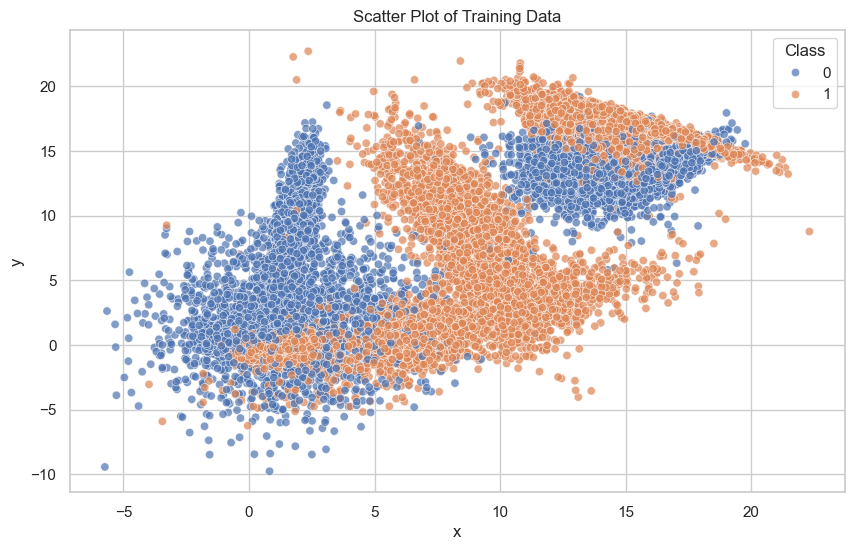

In [10]:
# Set the style of seaborn
sns.set_theme(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=train_data, x='x', y='y', hue='cls', palette='deep', alpha=0.7)

# Add titles and labels
plt.title('Scatter Plot of Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend(title='Class')
plt.show()


### Analyze the Data

In [11]:
# Check the distribution of classes
class_distribution = train_data['cls'].value_counts()
print(class_distribution)

# Summary statistics of the features
print(train_data.describe())


cls
1    12016
0    11984
Name: count, dtype: int64
                  x             y           cls
count  24000.000000  24000.000000  24000.000000
mean       6.897980      6.840433      0.500667
std        6.638242      6.826364      0.500010
min       -5.739819     -9.763944      0.000000
25%        0.887007      0.421379      0.000000
50%        4.531249      4.941289      1.000000
75%       13.588332     13.693109      1.000000
max       22.312527     22.722494      1.000000


# evaluate model

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate_model(model, X_train, y_train, X_test, y_test):
    # Predict on training data
    y_train_pred = model.predict(X_train)
    
    # Calculate metrics for training data
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    train_precision = precision_score(y_train, y_train_pred, average='weighted')
    train_recall = recall_score(y_train, y_train_pred, average='weighted')
    
    print("Training Metrics:")
    print(f"Accuracy: {train_accuracy:.4f}")
    print(f"F1 Score: {train_f1:.4f}")
    print(f"Precision: {train_precision:.4f}")
    print(f"Recall: {train_recall:.4f}")
    print()
    
    # Predict on testing data
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics for testing data
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    test_precision = precision_score(y_test, y_test_pred, average='weighted')
    test_recall = recall_score(y_test, y_test_pred, average='weighted')
    
    print("Testing Metrics:")
    print(f"Accuracy: {test_accuracy:.4f}")
    print(f"F1 Score: {test_f1:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall: {test_recall:.4f}")


# hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

def tune_hyperparameters(model, param_grid, X_train, y_train, scoring='accuracy', cv=5):
    
    print("Starting hyperparameter tuning...")
    
    # Initialize GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=cv, n_jobs=4, verbose=1)
    
    # Fit the model
    grid_search.fit(X_train, y_train)
    
    # Get the best model and parameters
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    
    print("\nHyperparameter Tuning Complete!")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validation Score: {best_score:.4f}")
    
    return best_model


### phase1: Bagging

In [14]:
from sklearn.tree import DecisionTreeClassifier

class Bagging:
    def __init__(self, base_model, n_estimators=10, random_state=None):
        """
        Custom implementation of the Bagging algorithm.

        Parameters:
        - base_model: The base model (e.g., DecisionTreeClassifier).
        - n_estimators: Number of estimators (default: 10).
        - random_state: Random seed for reproducibility (default: None).
        """
        self.base_model = base_model
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []
        self.bootstrap_samples = []

        # Seed for reproducibility
        if random_state:
            np.random.seed(random_state)

    def fit(self, X, y):
        """
        Fits the Bagging ensemble to the data.

        Parameters:
        - X: Feature matrix (numpy array or pandas DataFrame).
        - y: Target vector (numpy array or pandas Series).
        """
        self.models = []  # Reset models
        self.bootstrap_samples = []  # Reset bootstrap samples
        
        for _ in range(self.n_estimators):
            # Create a bootstrap sample
            indices = np.random.choice(len(X), size=len(X), replace=True)
            X_sample = X[indices]
            y_sample = y[indices]
            self.bootstrap_samples.append(indices)

            # Train a new base model
            model = self.base_model()
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        """
        Predicts the output for the given feature matrix using majority voting.

        Parameters:
        - X: Feature matrix (numpy array or pandas DataFrame).

        Returns:
        - Predictions (numpy array).
        """
        # Collect predictions from all models
        predictions = np.array([model.predict(X) for model in self.models])
        # Perform majority voting
        final_predictions = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
        return final_predictions


In [16]:
# Hyperparameter tuning
best_f1 = 0
best_params = {}

for n_estimators in [10, 20, 30]:
    # Create a Bagging model with Decision Tree as the base estimator
    base_tree = DecisionTreeClassifier()
    bagging_model = Bagging(base_estimator=base_tree, n_estimators=n_estimators)

    # Fit the model
    bagging_model.fit(X_train, y_train)

    # Make predictions
    y_pred_train = bagging_model.predict(X_train)
    y_pred_test = bagging_model.predict(X_test)

    # Calculate metrics
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')

    # Update best parameters
    if f1_test > best_f1:
        best_f1 = f1_test
        best_params = {'n_estimators': n_estimators}

    print(f'Params: n_estimators={n_estimators}, '
          f'Train F1: {f1_train:.4f}, Test F1: {f1_test:.4f}')

print(f'Best F1 Score: {best_f1:.4f} with parameters: {best_params}')


Params: n_estimators=10, Train F1: 0.9223, Test F1: 0.8218
Params: n_estimators=20, Train F1: 0.9217, Test F1: 0.8185
Params: n_estimators=30, Train F1: 0.9210, Test F1: 0.8155
Best F1 Score: 0.8218 with parameters: {'n_estimators': 10}


In [18]:
# Train the best model
best_bagging_model = Bagging(base_estimator=DecisionTreeClassifier(), n_estimators=best_params['n_estimators'])
best_bagging_model.fit(X_train, y_train)

# Predictions
y_pred_train_best = best_bagging_model.predict(X_train)
y_pred_test_best = best_bagging_model.predict(X_test)

# Calculate metrics for training set
precision_train = precision_score(y_train, y_pred_train_best, average='weighted')
recall_train = recall_score(y_train, y_pred_train_best, average='weighted')
f1_train_best = f1_score(y_train, y_pred_train_best, average='weighted')

# Calculate metrics for testing set
precision_test = precision_score(y_test, y_pred_test_best, average='weighted')
recall_test = recall_score(y_test, y_pred_test_best, average='weighted')
f1_test_best = f1_score(y_test, y_pred_test_best, average='weighted')

# Reporting metrics
print(f'Training Metrics: Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train_best:.4f}')
print(f'Testing Metrics: Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test_best:.4f}')


Training Metrics: Precision: 0.9200, Recall: 0.9200, F1 Score: 0.9200
Testing Metrics: Precision: 0.8193, Recall: 0.8193, F1 Score: 0.8193


IndexError: index 3 is out of bounds for axis 1 with size 3

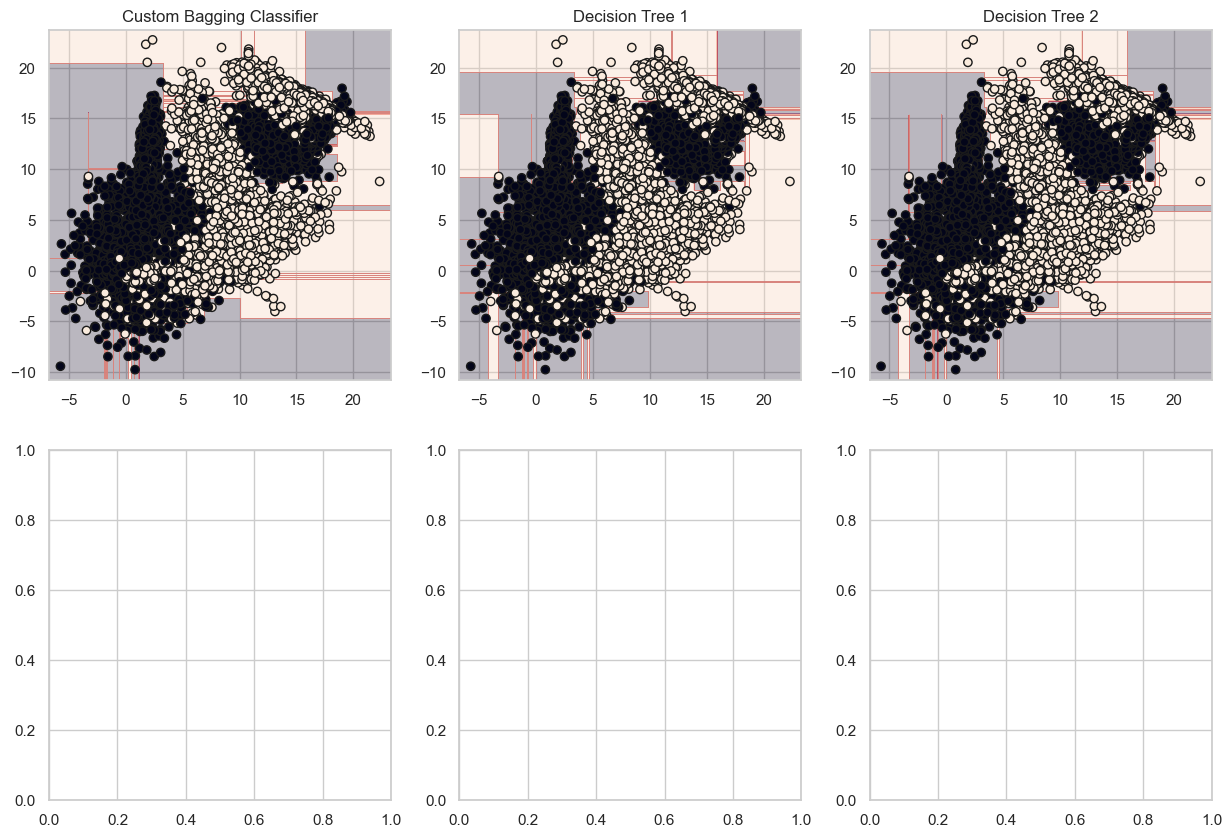

In [19]:
import matplotlib.pyplot as plt

def plot_decision_boundaries(classifier, X, y, ax, title):
    # Create a mesh grid for plotting
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    # Predict on the mesh grid
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plotting
    ax.contourf(xx, yy, Z, alpha=0.3)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    ax.set_title(title)

# Create a figure for plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Plot Bagging model
plot_decision_boundaries(best_bagging_model, X_train, y_train, axes[0, 0], 'Custom Bagging Classifier')

# Plot 5 Decision Tree classifiers with different random states
for i in range(5):
    tree_model = DecisionTreeClassifier(random_state=i)
    tree_model.fit(X_train, y_train)
    plot_decision_boundaries(tree_model, X_train, y_train, axes[i // 3, i % 3 + 1], f'Decision Tree {i + 1}')

plt.tight_layout()
plt.show()

# Using the library's BaggingClassifier
from sklearn.ensemble import BaggingClassifier

library_bagging_model = BaggingClassifier(n_estimators=best_params['n_estimators'])
library_bagging_model.fit(X_train, y_train)

# Predictions
y_pred_train_lib = library_bagging_model.predict(X_train)
y_pred_test_lib = library_bagging_model.predict(X_test)

# Calculate metrics for library model
precision_train_lib = precision_score(y_train, y_pred_train_lib, average='weighted')
recall_train_lib = recall_score(y_train, y_pred_train_lib, average='weighted')
f1_train_lib = f1_score(y_train, y_pred_train_lib, average='weighted')

precision_test_lib = precision_score(y_test, y_pred_test_lib, average='weighted')
recall_test_lib = recall_score(y_test, y_pred_test_lib, average='weighted')
f1_test_lib = f1_score(y_test, y_pred_test_lib, average='weighted')

# Reporting metrics for library model
print(f'Library Bagging Model Training Metrics: Precision: {precision_train_lib:.4f}, Recall: {recall_train_lib:.4f}, F1 Score: {f1_train_lib:.4f}')
print(f'Library Bagging Model Testing Metrics: Precision: {precision_test_lib:.4f}, Recall: {recall_test_lib:.4f}, F1 Score: {f1_test_lib:.4f}')

# Compare with custom Bagging model metrics
print(f'Custom Bagging Model Training Metrics: Precision: {precision_train:.4f}, Recall: {recall_train:.4f}, F1 Score: {f1_train_best:.4f}')
print(f'Custom Bagging Model Testing Metrics: Precision: {precision_test:.4f}, Recall: {recall_test:.4f}, F1 Score: {f1_test_best:.4f}')
